In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import gc
from IPython.display import clear_output

In [2]:
# Load the dataset
df = pd.read_csv('../dataset/train_val.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display a few rows
df.head()

Dataset shape: (15482, 8)
Columns: ['Unnamed: 0', 'id', 'channel', 'title', 'date', 'description', 'views', 'year']


,Unnamed: 0,id,channel,title,date,description,views,year
0,0,--2s6hjGrm4,UC-1rx8j9Ggp8mp4uD0ZdEIA,"CGI & VFX Breakdowns: ""Warzone"" - by Ramesh Th...",2020-12-15 05:00:01+00:00,"Check out this revealing VFX Breakdown ""Warzon...",12299,2020
1,1,--DnfroyKQ8,UC-1rx8j9Ggp8mp4uD0ZdEIA,"A Sci-Fi Short Film: ""Exit"" - by Ng King Kwan ...",2020-07-01 16:00:00+00:00,"TheCGBros Presents ""Exit"" by Ng King Kwan - Th...",7494,2020
2,2,--aiU7VQKEw,UC-1rx8j9Ggp8mp4uD0ZdEIA,"CGI 3D Animated Short: ""Lost Love"" - by Akash ...",2019-02-18 20:30:00+00:00,"TheCGBros Presents ""Lost Love"" by Akash Manack...",11831,2019
3,6,-0SrlZAvSVM,UCW6NyJ6oFLPTnx7iGRZXDDg,Jo Goes Hunting - Careful | Animated music vid...,2020-03-10 14:30:01+00:00,"On the borderless map of a magical planet, lit...",2248,2020
4,10,-13Y2Pe7kFs,UC-1rx8j9Ggp8mp4uD0ZdEIA,"CGI VFX Breakdown: ""Logan (Wolverine): Digital...",2017-09-20 20:13:52+00:00,Check out this outstanding behind-the-scenes l...,113806,2017


In [3]:
# Feature engineering
df['date'] = pd.to_datetime(df['date'])

# Extract date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter

# Check if date has timezone information
has_tz = df['date'].dt.tz is not None

# Fix the timezone issue with days_since_upload calculation
if has_tz:
    # Method 1: Make reference date timezone-aware
    from datetime import timezone
    reference_date = datetime.now(timezone.utc)
else:
    # Method 2: Use a timezone-naive reference date
    reference_date = pd.Timestamp.now().tz_localize(None)


# Calculate days since upload (using the date of the most recent video as reference)
df['days_since_upload'] = (reference_date - df['date']).dt.days

# Encode channel names
channel_encoder = LabelEncoder()
df['channel_encoded'] = channel_encoder.fit_transform(df['channel'])

# Create train-validation split
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")

Training set: 12385 samples
Validation set: 3097 samples


In [4]:
from dataset import VideoViewsDataset
from torch.utils.data import DataLoader

# Create datasets and dataloaders
train_dataset = VideoViewsDataset(df_train)
val_dataset = VideoViewsDataset(df_val)

BATCH_SIZE = 64
NUM_WORKERS = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)

In [5]:
from model import ViewsPredictor

# Create model
num_channels = len(channel_encoder.classes_)
model = ViewsPredictor(num_channels)
print(model)

ViewsPredictor(
  (channel_embedding): Embedding(46, 16)
  (regressor): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [6]:
# Training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.HuberLoss(delta=1.0) 

# Lists to store metrics
train_losses = []
val_losses = []
batch_losses = []

Using device: cuda


In [7]:
# Create a function to update the plot
def plot_losses():
    clear_output(wait=True)
    plt.figure(figsize=(15, 6))
    
    # Plot batch losses
    plt.subplot(1, 3, 1)
    plt.plot(batch_losses)
    plt.title('Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot epoch losses
    plt.subplot(1, 3, 2)
    if len(train_losses) > 0:
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, 'b-', label='Training')
        plt.plot(epochs, val_losses, 'r-', label='Validation')
        plt.title('Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    
    # Plot training vs validation loss - different scale for better visualization
    plt.subplot(1, 3, 3)
    if len(train_losses) > 0:
        plt.plot(epochs, train_losses, 'bo-', label='Training')
        plt.plot(epochs, val_losses, 'ro-', label='Validation')
        plt.title('Training vs. Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

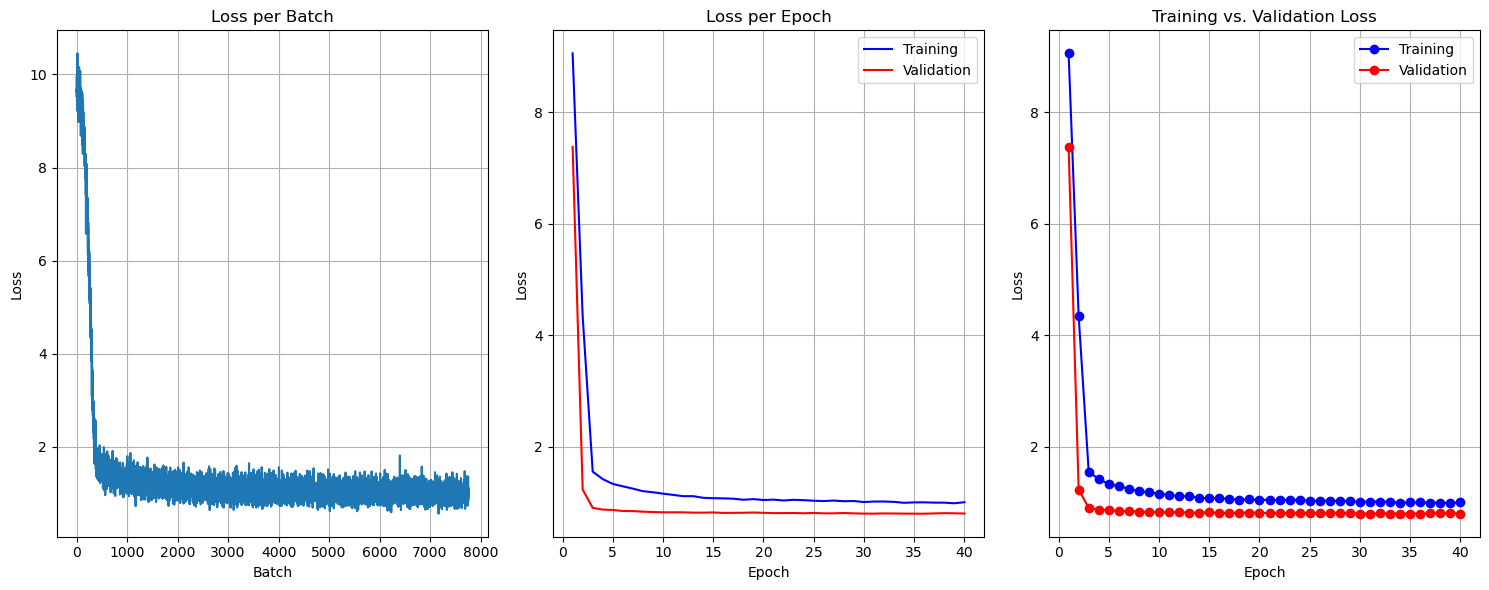

In [8]:
# Training loop
EPOCHS = 40
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0.0
    
    for i, (channel_ids, numeric_features, targets) in enumerate(train_loader):
        # Move data to device
        channel_ids = channel_ids.to(device)
        numeric_features = numeric_features.to(device)
        targets = targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(channel_ids, numeric_features)
        loss = loss_fn(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Record loss
        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        total_train_loss += batch_loss * len(targets)
        
        # Move tensors to CPU to free GPU memory
        channel_ids = channel_ids.cpu()
        numeric_features = numeric_features.cpu()
        targets = targets.cpu()
        
    
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for channel_ids, numeric_features, targets in val_loader:
            # Move data to device
            channel_ids = channel_ids.to(device)
            numeric_features = numeric_features.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(channel_ids, numeric_features)
            val_loss = loss_fn(outputs, targets)
            total_val_loss += val_loss.item() * len(targets)
            
            # Move tensors to CPU to free GPU memory
            channel_ids = channel_ids.cpu()
            numeric_features = numeric_features.cpu()
            targets = targets.cpu()
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_dataset)
    avg_val_loss = total_val_loss / len(val_dataset)
    
    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_views_predictor.pth")
        print(f"✅ Model saved with improved validation loss: {best_val_loss:.4f}")
    
    # Free up memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # Update the plot
    plot_losses()

# Final plot
plot_losses()

In [9]:
# Save the final model
torch.save(model.state_dict(), "final_views_predictor.pth")

Evaluating:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 49/49 [00:00<00:00, 486.36it/s]

Validation Results:
MSE: 2.8620
RMSE: 1.6917
MAE: 1.1853
R²: 0.3945


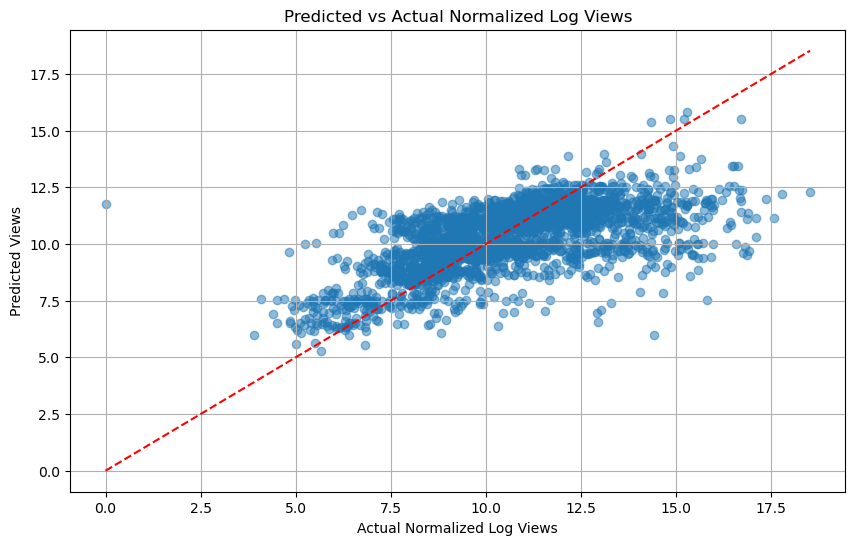

In [12]:
# Load the best model for evaluation
model = ViewsPredictor(num_channels)
model.load_state_dict(torch.load("best_views_predictor.pth"))
model.to(device)
model.eval()

# Evaluate on validation set
predictions = []
actual = []
ids = []

with torch.no_grad():
    for channel_ids, numeric_features, targets in tqdm(val_loader, desc="Evaluating"):
        channel_ids = channel_ids.to(device)
        numeric_features = numeric_features.to(device)
        
        outputs = model(channel_ids, numeric_features)
        
        # Convert log predictions back to original scale
        pred_views = outputs.cpu().numpy()
        actual_views = targets.numpy()
        
        predictions.extend(pred_views.tolist())
        actual.extend(actual_views.tolist())
    
# Store validation set IDs
ids = df_val['id'].values.tolist()

# Create results dataframe
results = pd.DataFrame({
    'id': ids[:len(predictions)],
    'predicted_logn_views': predictions,
    'actual_logn_views': actual[:len(predictions)]
})

# Calculate metrics
mse = mean_squared_error(results['actual_logn_views'], results['predicted_logn_views'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(results['actual_logn_views'], results['predicted_logn_views'])
r2 = r2_score(results['actual_logn_views'], results['predicted_logn_views'])

print(f"Validation Results:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(results['actual_logn_views'], results['predicted_logn_views'], alpha=0.5)
plt.plot([min(results['actual_logn_views']), max(results['actual_logn_views'])], 
         [min(results['actual_logn_views']), max(results['actual_logn_views'])], 'r--')
plt.xlabel('Actual Normalized Log Views')
plt.ylabel('Predicted Views')
plt.title('Predicted vs Actual Normalized Log Views')
plt.grid(True)
plt.show()


Evaluating: 100%|██████████| 194/194 [00:00<00:00, 325.73it/s]


Train Results:
MSE: 15831853830931.7910
RMSE: 3978926.2158
MAE: 543687.3475
R²: -0.0090


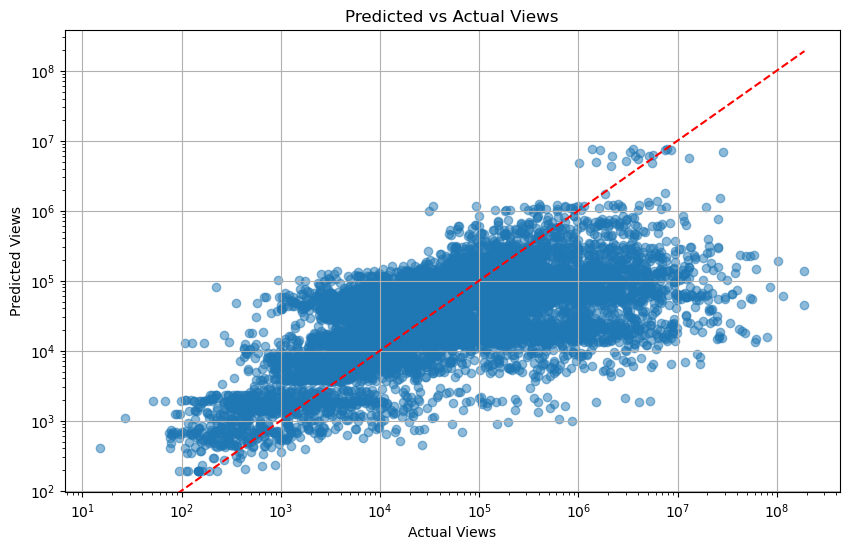

In [11]:
# Evaluate on train set
predictions = []
actual = []
ids = []

with torch.no_grad():
    for channel_ids, numeric_features, targets in tqdm(train_loader, desc="Evaluating"):
        channel_ids = channel_ids.to(device)
        numeric_features = numeric_features.to(device)
        
        outputs = model(channel_ids, numeric_features)
        
        # Convert log predictions back to original scale
        pred_views = torch.expm1(outputs).cpu().numpy()
        actual_views = torch.expm1(targets).numpy()
        
        predictions.extend(pred_views.tolist())
        actual.extend(actual_views.tolist())
    
# Store validation set IDs
ids = df_train['id'].values.tolist()

# Create results dataframe
results = pd.DataFrame({
    'id': ids[:len(predictions)],
    'predicted_views': predictions,
    'actual_views': actual[:len(predictions)]
})

# Calculate metrics
mse = mean_squared_error(results['actual_views'], results['predicted_views'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(results['actual_views'], results['predicted_views'])
r2 = r2_score(results['actual_views'], results['predicted_views'])

print(f"Train Results:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(results['actual_views'], results['predicted_views'], alpha=0.5)
plt.plot([min(results['actual_views']), max(results['actual_views'])], 
         [min(results['actual_views']), max(results['actual_views'])], 'r--')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Predicted vs Actual Views')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


The model first transforms views to log scale (since view counts are typically log-distributed), then learns patterns from channel identity and temporal features. Channel embeddings are particularly powerful as they can encode the "popularity factor" of each channel.

The validation plots and metrics show how well the model generalizes to unseen data, and we've also included analysis of feature importance to understand what drives predictions.

The model honestly doesn't seem too overfitted. 

In [13]:
from dataset import VideoViewsDataset
from torch.utils.data import DataLoader

# Make predictions for the entire dataset
print("Generating predictions for the entire dataset...")

# Create a dataset for the entire data

full_dataset = VideoViewsDataset(df)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

# Make predictions
all_predictions = []
all_ids = df['id'].values.tolist()

with torch.no_grad():
    for channel_ids, numeric_features, targets in tqdm(full_loader, desc="Predicting"):
        channel_ids = channel_ids.to(device)
        numeric_features = numeric_features.to(device)
        
        outputs = model(channel_ids, numeric_features)
        pred_views = outputs.cpu().numpy()
        
        all_predictions.extend(pred_views.tolist())

# Create results dataframe for all data
full_results = pd.DataFrame({
    'id': all_ids[:len(all_predictions)],
    'predicted_logn_views': all_predictions,
    'actual_logn_views': np.log1p(df['views'].values[:len(all_predictions)])
})

# Calculate metrics for full dataset
mse = mean_squared_error(full_results['actual_logn_views'], full_results['predicted_logn_views'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(full_results['actual_logn_views'], full_results['predicted_logn_views'])
r2 = r2_score(full_results['actual_logn_views'], full_results['predicted_logn_views'])

print(f"Full Dataset Results:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Create predictions in original (non-log) scale
full_results['predicted_views'] = np.expm1(full_results['predicted_logn_views'])
full_results['actual_views'] = df['views'].values[:len(all_predictions)]

# Save results
full_results.to_csv('full_dataset_predictions.csv', index=False)

print("Predictions saved to full_dataset_predictions.csv")

Generating predictions for the entire dataset...


Predicting: 100%|██████████| 242/242 [00:00<00:00, 807.17it/s]


Full Dataset Results:
MSE: 2.8396
RMSE: 1.6851
MAE: 1.1784
R²: 0.4133
Predictions saved to full_dataset_predictions.csv
